In [1]:
from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import pandas as pd
import timeit
from tqdm import tqdm

import numpy as np
import random
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.integrate import simps
import matplotlib.pyplot as plt
import matplotlib

import signal_generation as sg
from importlib import reload
reload(sg)
from ssfm import fiber_propogate

In [2]:
mod_type = "16qam"
n_car = 1
t_symb = 1.0
n_symb = 32
dt = t_symb / n_symb

num_symbols = 4
n_lateral = 16 * n_symb
# p_ave = 0.74
p_ave = 0.02
roll_off = 0.01

data = sg.gen_wdm_bit_sequence(num_symbols, mod_type, n_car)
points = sg.get_constellation_point(data, mod_type)
signal = sg.get_wdm_signal(data, t_symb=t_symb, n_symb=n_symb,
                        func=sg.srrcos, func_args=[t_symb, roll_off],
                        n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))
signal = sg.add_lateral(signal, 2**12 - len(signal) // 2)

n = len(signal)
print(n)
t_span = dt * n

beta2 = -1.0
gamma = 1.0
# energy_init = get_energy(signal, t_span)

z_prop = 1
signal_prop = fiber_propogate(signal, t_span, z_prop, 2 ** 13, gamma=gamma, beta2=beta2)


8192


In [3]:
# make dispersion compensation
w = fftshift([(i - n / 2) * (2. * np.pi / t_span) for i in range(n)])
signal_compensated = sg.dispersion_compensation_t(signal_prop, w, z_prop, beta2)

# get points from WDM and scale
points_restore = sg.get_points_wdm(signal_compensated, t_symb=t_symb, n_symb=n_symb,
                                func=sg.rcos, func_args=[t_symb, roll_off],
                                n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
scale = sg.get_scale_coef(points_restore, mod_type)
points_restore = scale * points_restore

# find nearest constellation points
point_found = sg.get_nearest_constellation_points(points_restore, mod_type)
print("PER:", sg.get_points_error_rate(points, point_found))

# make PSE
points_rotated = sg.make_pse(points, points_restore, mod_type)
point_found_r = sg.get_nearest_constellation_points(points_rotated, mod_type)
print("PER:", sg.get_points_error_rate(points, point_found_r))

data_restored = sg.get_bits_from_constellation_points(point_found_r, mod_type)
print("BER:", sg.get_bits_error_rate(data, data_restored))

Error: different bits sequence sizes: 4 224
PER: 1.0
Error: different bits sequence sizes: 4 224


TypeError: 'float' object is not subscriptable

Here we will use NFT to compensation

In [ ]:
np_signal = len(signal)
np_spectrum = 2 * np_signal

t_vector = np.array([(i - np_signal / 2) * dt for i in range(np_signal)])

# calculate suitable frequency bonds (xi)
rv, xi_bound = nsev_inverse_xi_wrapper(np_signal, t_vector[0], t_vector[-1], np_spectrum)
xi_vector = xi_bound[0] + np.arange(np_spectrum) * (xi_bound[1] - xi_bound[0]) / (np_spectrum - 1)

res = nsev(signal_prop, t_vector, M=np_spectrum, Xi1=xi_bound[0], Xi2=xi_bound[1], kappa=1)

cont_spec = res['cont_ref']
bound_states = res['bound_states']
print(len(bound_states), bound_states)
disc_norm = res['disc_norm']

# bound_states = []
# disc_norm = []

z_prop_nft = -z_prop
cont_spec_prop = cont_spec * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(xi_vector), 2))
disc_norm_prop = disc_norm * np.exp(-2. * 1.0j * z_prop_nft * np.power(np.array(bound_states), 2))

res_bprop = nsev_inverse(xi_vector, t_vector, cont_spec_prop, bound_states, disc_norm_prop, cst=0, dst=0)

signal_bprop_nft = res_bprop['q']

In [188]:
# get points from WDM and scale
points_restore_nft = sg.get_points_wdm(signal_bprop_nft, t_symb=t_symb, n_symb=n_symb,
                                func=sg.rcos, func_args=[t_symb, roll_off],
                                n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
scale = sg.get_scale_coef(points_restore_nft, mod_type)
points_restore_nft = scale * points_restore_nft

# find nearest constellation points
point_found_nft = sg.get_nearest_constellation_points(points_restore_nft, mod_type)
print("PER:", sg.get_points_error_rate(points, point_found_nft))

# # make PSE
# points_rotated = sg.make_pse(points, points_restore, mod_type)
# point_found_r = sg.get_nearest_constellation_points(points_rotated, mod_type)
# print("PER:", sg.get_points_error_rate(points, point_found_r))

data_restored_nft = sg.get_bits_from_constellation_points(point_found_nft, mod_type)
print("BER:", sg.get_bits_error_rate(data, data_restored_nft))

Error: different bits sequence sizes: 4 64
PER: 1.0
Error: different bits sequence sizes: 16 256
BER: 1.0


<ipython-input-238-3d81b1c514ab>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


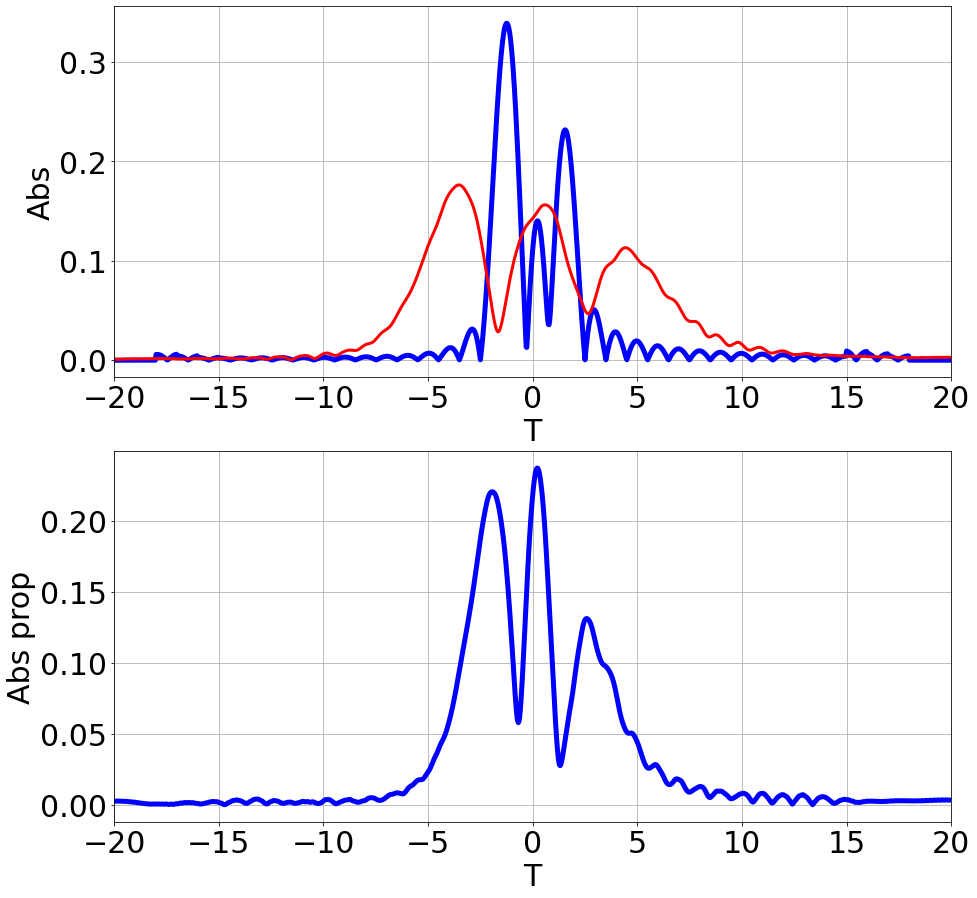

<ipython-input-242-3d81b1c514ab>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


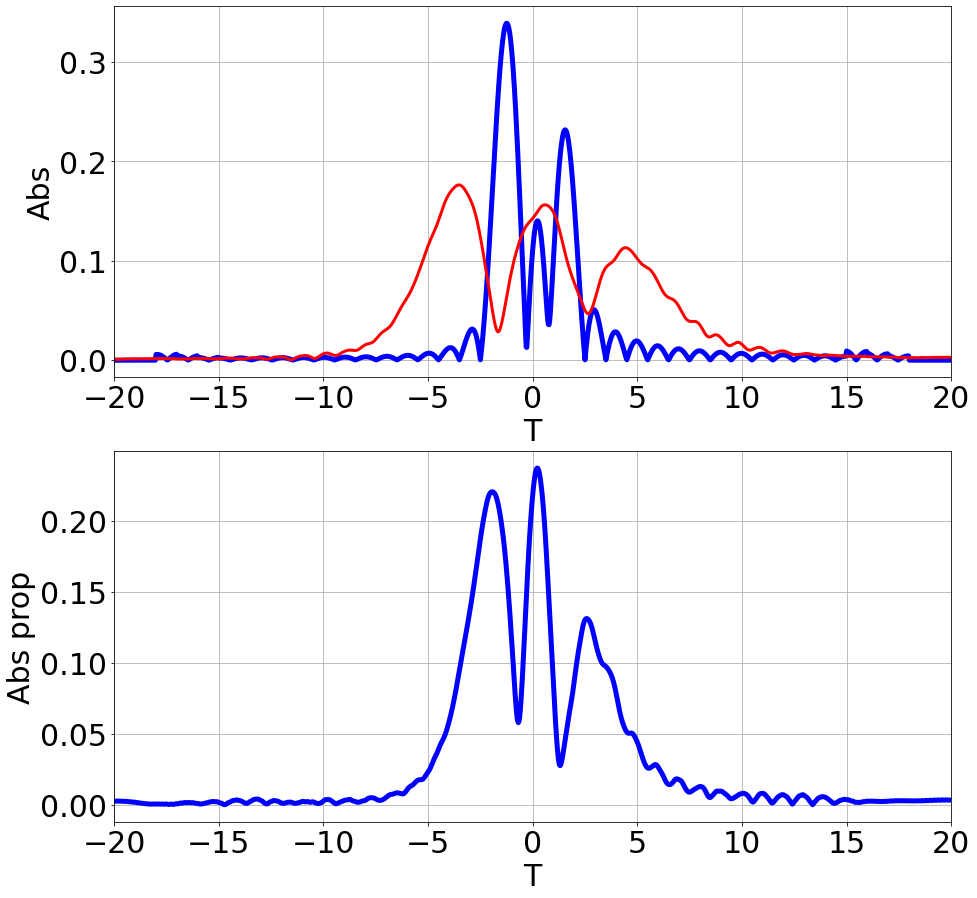

In [242]:
# draw signal nft

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(t_vector, np.absolute(signal),
            color='blue', linewidth=5.0)
axs[0].plot(t_vector, np.absolute(signal_bprop_nft),
            color='red', linewidth=3.0)
axs[0].set_xlim(-20, 20)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

axs[1].plot(t_vector, np.absolute(signal_prop),
            color='blue', linewidth=5.0)
# axs[1].plot(t_vector, np.absolute(signal_bprop_nft),
#             color='red', linewidth=3.0)
axs[1].set_xlim(-20, 20)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs prop')
axs[1].grid(True)

fig.show()

ValueError: operands could not be broadcast together with shapes (4,) (32,) 

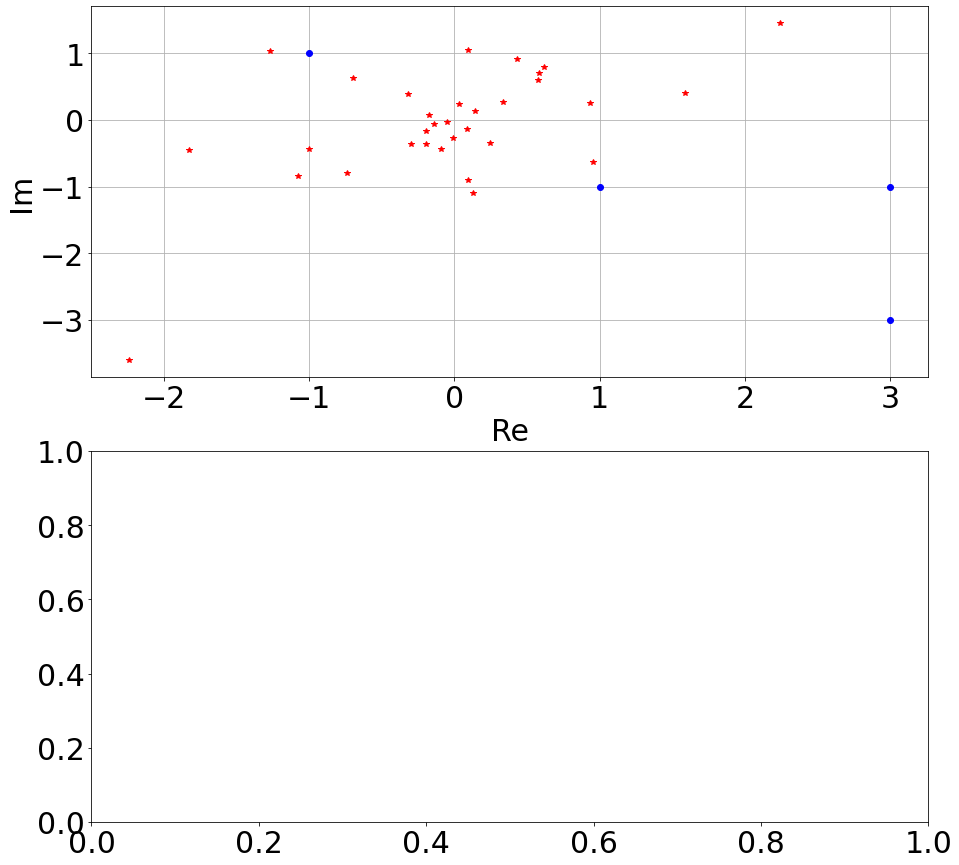

In [125]:
# draw constellation nft

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(np.real(points), np.imag(points),
            marker='o', color='blue', ls='')
axs[0].plot(np.real(points_restore_nft), np.imag(points_restore_nft),
            marker='*', color='red', ls='')
# axs[0].set_xlim(-5, 5)
axs[0].set_xlabel('Re')
axs[0].set_ylabel('Im')
axs[0].grid(True)

axs[1].plot(np.real(points - points_restore_nft), np.imag(points - points_restore_nft),
            marker='o', color='blue', ls='')
axs[1].set_xlabel('Re')
axs[1].set_ylabel('Im')
axs[1].grid(True)

fig.show()

<ipython-input-15-eeb46d119965>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


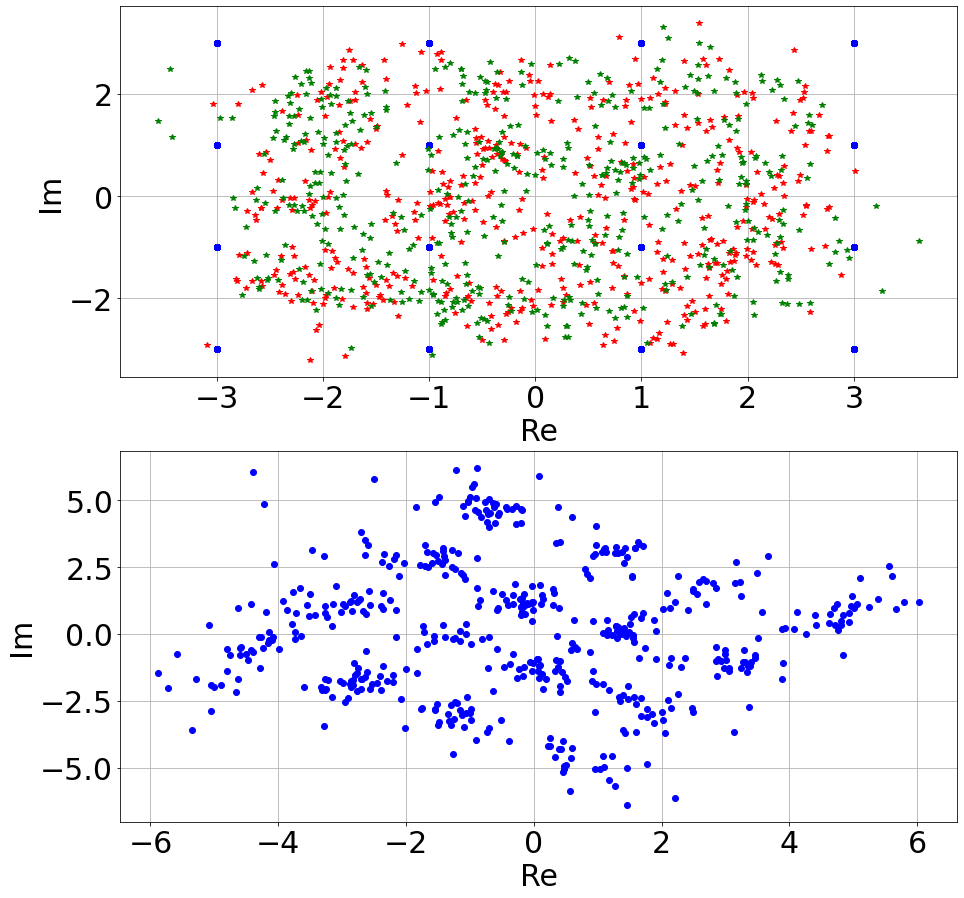

In [15]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(np.real(points), np.imag(points),
            marker='o', color='blue', ls='')
axs[0].plot(np.real(points_restore), np.imag(points_restore),
            marker='*', color='red', ls='')
axs[0].plot(np.real(points_rotated), np.imag(points_rotated),
            marker='*', color='green', ls='')
# axs[0].set_xlim(-5, 5)
axs[0].set_xlabel('Re')
axs[0].set_ylabel('Im')
axs[0].grid(True)

axs[1].plot(np.real(points - points_restore), np.imag(points - points_restore),
            marker='o', color='blue', ls='')
axs[1].set_xlabel('Re')
axs[1].set_ylabel('Im')
axs[1].grid(True)

fig.show()

In [ ]:
# draw signal with zeros

signal_test = signal
np_test = len(signal)
t_vec_test = np.array([(i - np_test / 2) * dt for i in range(np_test)])

signal_test_new = sg.add_lateral(signal)
np_test_new = len(signal_test_new)
t_vec_test_new = np.array([(i - np_test_new / 2) * dt for i in range(np_test_new)])

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(t_vec_test, np.absolute(signal_test),
            color='blue', linewidth=5.0)
axs[0].plot(t_vec_test_new, np.absolute(signal_test_new),
            color='red', linewidth=3.0)
# axs[0].set_xlim(-5, 5)
axs[0].set_xlabel('T')
axs[0].set_ylabel('Abs')
axs[0].grid(True)

n_test_slice = np_test // 2
axs[1].plot(t_vec_test, np.absolute(signal_test_new[n_test_slice : n_test_slice + np_test] - signal_test),
            color='blue', linewidth=5.0)
axs[1].set_xlabel('T')
axs[1].set_ylabel('Abs')
axs[1].grid(True)

fig.show()



In [12]:
a = 10 * np.log10(0.74 * 21.5 / 1.27 * (100) ** (-2) * 1000)
print(a)

0.978664586906247


In [ ]:
import signal_generation as sg
from importlib import reload
reload(sg)

mod_type = "16qam"
n = 10000 * sg.get_n_bits(mod_type)
a = sg.gen_bit_sequence(n)
print(a)
b = sg.get_constellation_point(a, mod_type)
print(len(b))
res = ''
for i in range(len(b)):
    temp = sg.get_bits_from_constellation_point(b[i], mod_type)
    # print(len(temp), temp)
    res = res + temp

print(sg.get_bits_error_rate(a, res))


